In [296]:
import pandas as pd
import seaborn as sns
import numpy as np
from os import listdir
from itertools import product
import matplotlib.pyplot as plt

# Execution Times


In [297]:
graph_types = ["scf", "gnp", "smw"]
algo_types  = ["fixed", "floating"]
optim_type  = ['no_optim', 'l2_norm_bitmask', 'l2_norm']

measurements = pd.DataFrame()

for g in graph_types: 
    for a in algo_types: 
        csvs = [f"../new_ds/measurements/{g}/{a}/{filename}" for filename in listdir(f"../new_ds/measurements/{g}/{a}") if '.csv' in filename]
        temp = pd.DataFrame()
        for el in csvs:
            temp = pd.read_csv(el)
            temp["algo"] = a
            temp["graph"] = g
            temp["optim"] = el.split('/')[-1].split('.')[0]
            measurements = measurements.append(temp, ignore_index=True)

In [298]:
measurements.head()


,Type,Time(%),Time,Calls,Avg,Min,Max,Name,algo,graph,optim
0,GPU activities,49.613819,22.710414,200,113.552,112.129,116.225,"void d_fixed_spmv<__int64>(__int64*, __int64*,...",fixed,scf,no_optim
1,GPU activities,16.186835,7.409422,200,37.047,36.576,37.504,"void d_fixed_axpb<__int64>(__int64*, __int64, ...",fixed,scf,no_optim
2,GPU activities,14.149701,6.476937,200,32.384,31.809,32.993,"void d_fixed_compute_error<__int64>(__int64*, ...",fixed,scf,no_optim
3,GPU activities,6.602098,3.022069,200,15.110,14.944,15.456,void thrust::cuda_cub::cub::DeviceReduceKernel...,fixed,scf,no_optim
4,GPU activities,5.018524,2.297198,200,11.485,11.040,13.248,[CUDA memcpy DtoD],fixed,scf,no_optim


In [299]:
measurements["final_exec_time"] = 0
measurements["new_idx"] = list(range(measurements.shape[0]))

In [300]:
for algo, graph, optim in product(algo_types,graph_types, optim_type): 
    partial_gpu_act = measurements[(measurements["Type"] == "GPU activities") & (measurements["algo"] == algo) & (measurements["graph"] == graph) & (measurements["optim"] == optim)]
    idx             = partial_gpu_act["new_idx"]
    if partial_gpu_act.shape[0] != 0: 
        total_exec_time = partial_gpu_act.apply(lambda x: x["Time"], axis=1).sum()
        print(f"{algo} point on {graph} with {optim} -> {str(total_exec_time)}ms")
        measurements.loc[idx, "final_exec_time"] = total_exec_time

fixed point on scf with no_optim -> 45.77437200000001ms
fixed point on scf with l2_norm_bitmask -> 27.301164000000004ms
fixed point on scf with l2_norm -> 27.125438000000003ms
fixed point on gnp with no_optim -> 46.256420999999996ms
fixed point on gnp with l2_norm_bitmask -> 23.060441ms
fixed point on gnp with l2_norm -> 22.909769999999995ms
fixed point on smw with no_optim -> 48.942784ms
fixed point on smw with l2_norm_bitmask -> 15.717561ms
fixed point on smw with l2_norm -> 15.417548ms
floating point on scf with no_optim -> 45.62026099999999ms
floating point on scf with l2_norm_bitmask -> 27.882547000000002ms
floating point on scf with l2_norm -> 26.788496999999996ms
floating point on gnp with no_optim -> 46.44704200000001ms
floating point on gnp with l2_norm_bitmask -> 23.317625999999997ms
floating point on gnp with l2_norm -> 22.548111ms
floating point on smw with no_optim -> 48.70832600000001ms
floating point on smw with l2_norm_bitmask -> 15.68874ms
floating point on smw with l2

In [301]:
measurements = measurements[~(measurements["Type"] == "API calls")][['Type', 'Time(%)', 'Time', 'Calls', 'Avg', 'Min', 'Max', 'Name', 'algo',
       'graph', 'optim', 'final_exec_time']]

In [302]:
for g_idx, rest in measurements.groupby("graph"): 
    print(f"Fastest for {g_idx}")
    print("\t", rest[rest["final_exec_time"] == rest["final_exec_time"].min()]["algo"].unique()[0], rest[rest["final_exec_time"] == rest["final_exec_time"].min()]["optim"].unique()[0])

Fastest for gnp
	 floating l2_norm
Fastest for scf
	 floating l2_norm
Fastest for smw
	 fixed l2_norm


/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


<Figure size 1440x720 with 0 Axes>

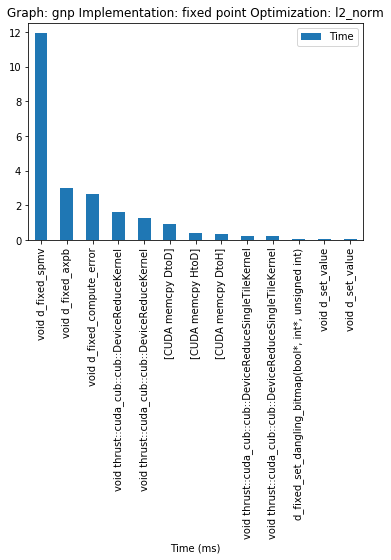

<Figure size 1440x720 with 0 Axes>

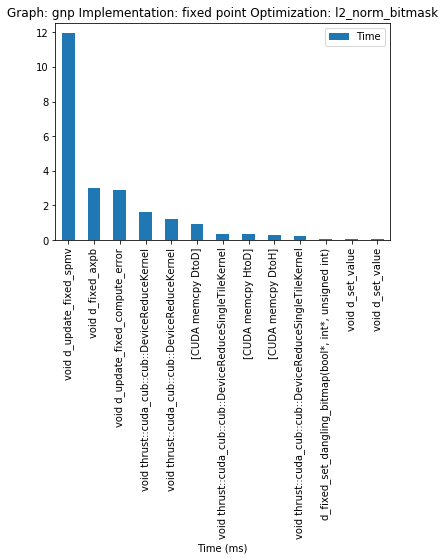

<Figure size 1440x720 with 0 Axes>

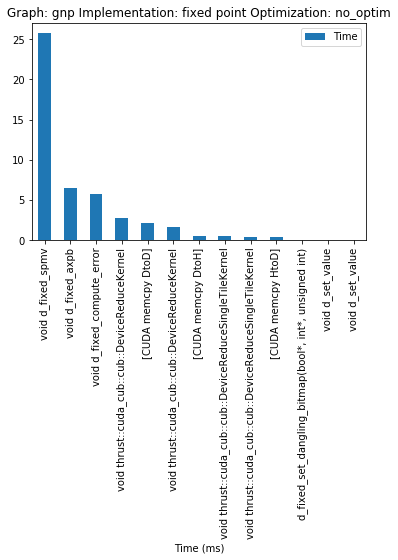

<Figure size 1440x720 with 0 Axes>

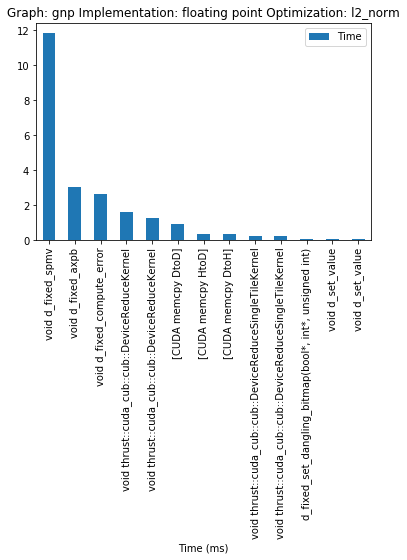

<Figure size 1440x720 with 0 Axes>

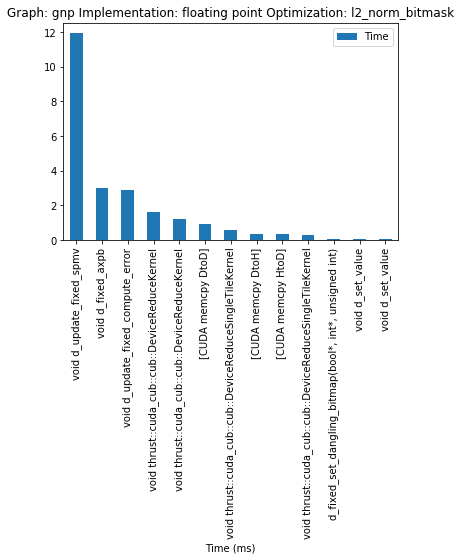

<Figure size 1440x720 with 0 Axes>

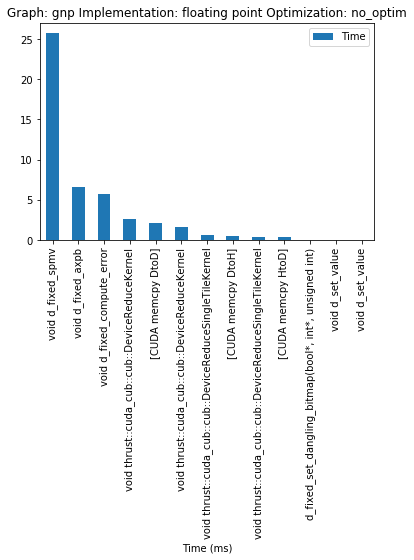

<Figure size 1440x720 with 0 Axes>

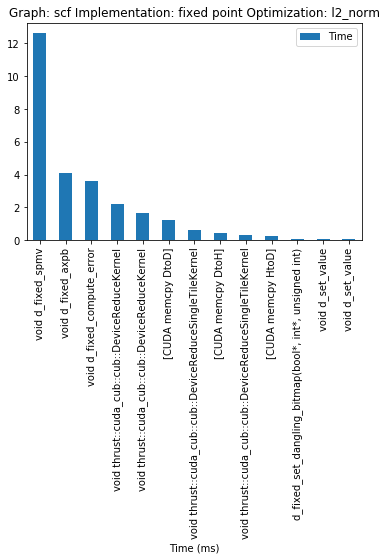

<Figure size 1440x720 with 0 Axes>

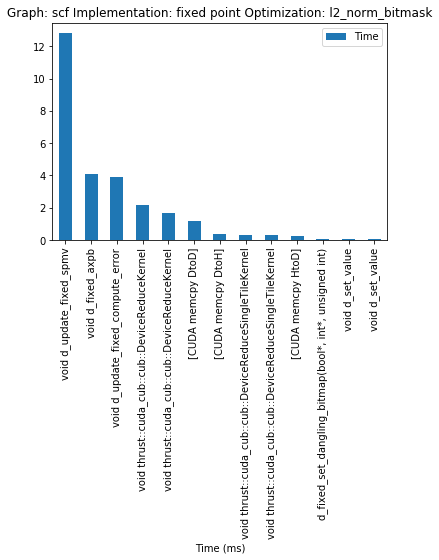

<Figure size 1440x720 with 0 Axes>

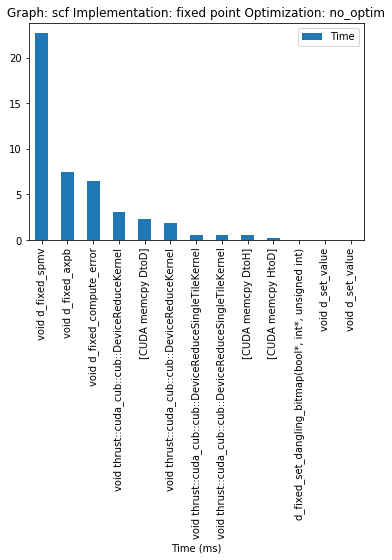

<Figure size 1440x720 with 0 Axes>

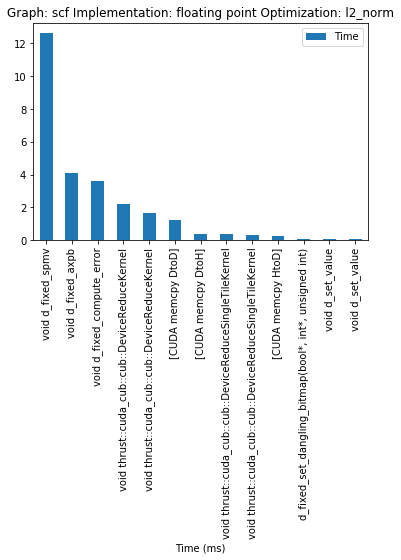

<Figure size 1440x720 with 0 Axes>

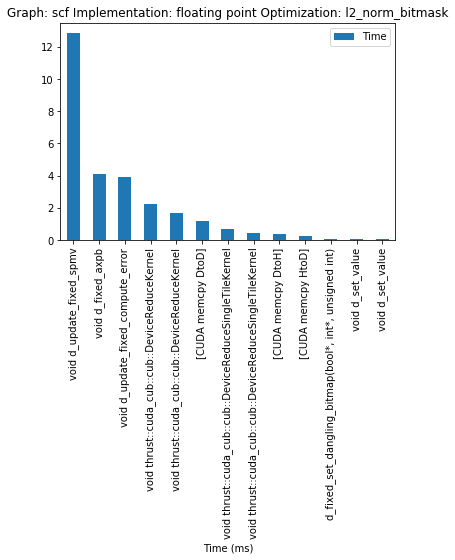

<Figure size 1440x720 with 0 Axes>

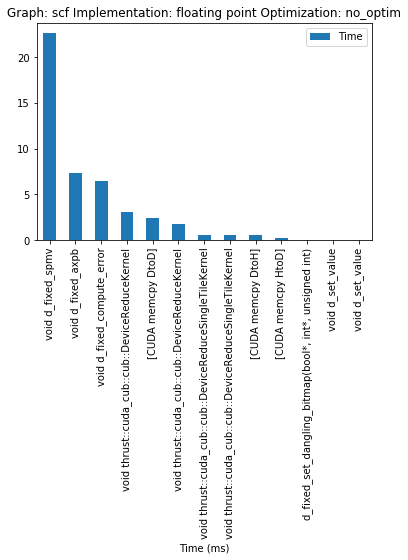

<Figure size 1440x720 with 0 Axes>

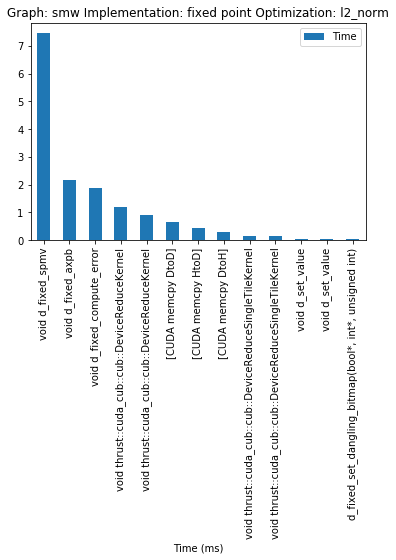

<Figure size 1440x720 with 0 Axes>

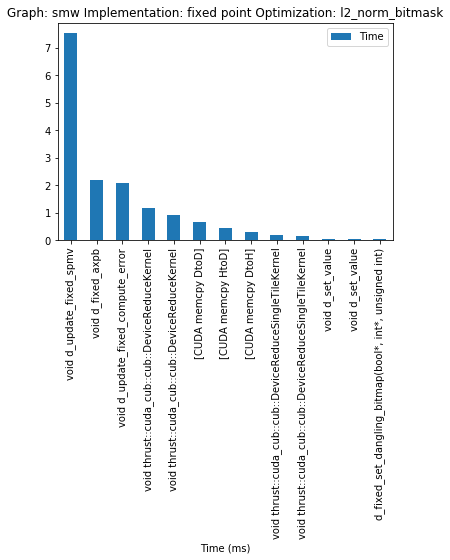

<Figure size 1440x720 with 0 Axes>

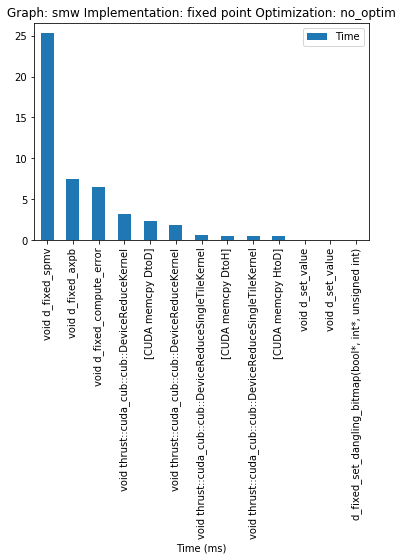

<Figure size 1440x720 with 0 Axes>

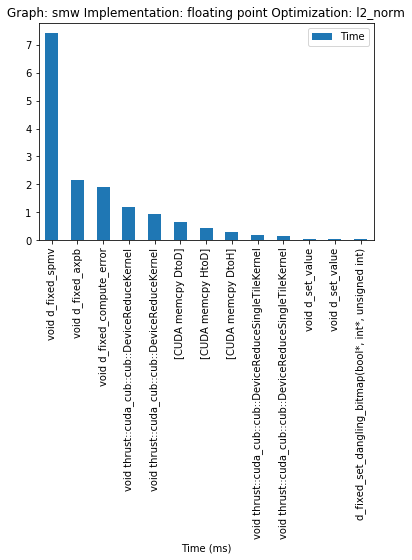

<Figure size 1440x720 with 0 Axes>

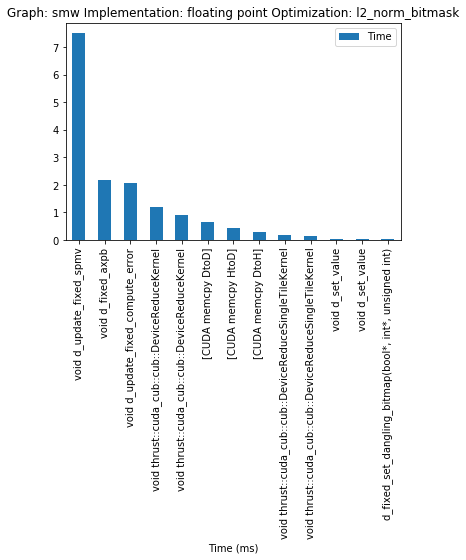

<Figure size 1440x720 with 0 Axes>

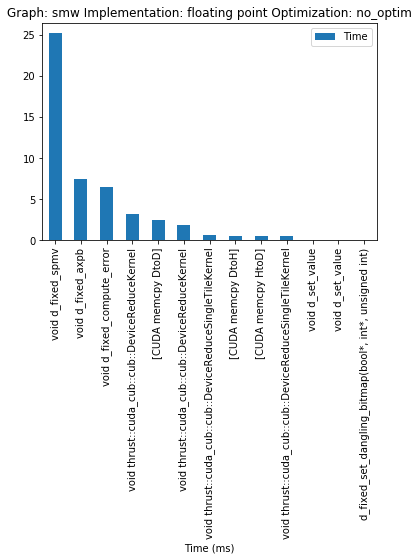

In [303]:
for g_idx, rest in measurements.groupby(["graph", "algo", "optim"]):
    formatted_fn_names = list(map(lambda x: x.split('<')[0], rest["Name"].unique()))
    plt.figure(figsize=(20, 10))
    x =  rest[["Time", "Name"]]
    x["Name"] = x["Name"].apply(lambda x: x.split("<")[0])
    x = x.set_index('Name')
    ax = x.plot(kind="bar", title=f"Graph: {g_idx[0]} Implementation: {g_idx[1]} point Optimization: {g_idx[2]}")
    ax.set_xlabel("Time (ms)")
    plt.savefig(f'figures/function_execution_time/{g_idx[0]}_{g_idx[1]}_{g_idx[2]}.png')
    

In [304]:
measurements.head()

,Type,Time(%),Time,Calls,Avg,Min,Max,Name,algo,graph,optim,final_exec_time
0,GPU activities,49.613819,22.710414,200,113.552,112.129,116.225,"void d_fixed_spmv<__int64>(__int64*, __int64*,...",fixed,scf,no_optim,45.774372
1,GPU activities,16.186835,7.409422,200,37.047,36.576,37.504,"void d_fixed_axpb<__int64>(__int64*, __int64, ...",fixed,scf,no_optim,45.774372
2,GPU activities,14.149701,6.476937,200,32.384,31.809,32.993,"void d_fixed_compute_error<__int64>(__int64*, ...",fixed,scf,no_optim,45.774372
3,GPU activities,6.602098,3.022069,200,15.110,14.944,15.456,void thrust::cuda_cub::cub::DeviceReduceKernel...,fixed,scf,no_optim,45.774372
4,GPU activities,5.018524,2.297198,200,11.485,11.040,13.248,[CUDA memcpy DtoD],fixed,scf,no_optim,45.774372


In [305]:
times = pd.DataFrame(columns=["graph", "algo", "optim", "time"])


for g_idx, rest in measurements.groupby(["graph", "algo", "optim"]):
    graph, algo, optim = g_idx
    ds = {}
    ds["graph"] = graph
    ds["algo"] = algo
    ds["optim"] = optim
    ds["time"] = rest["final_exec_time"].unique()[0]
    times = times.append(ds, ignore_index=True)


In [310]:
times.head()

,graph,algo,optim,time
0,gnp,fixed,l2_norm,22.909770
1,gnp,fixed,l2_norm_bitmask,23.060441
2,gnp,fixed,no_optim,46.256421
3,gnp,floating,l2_norm,22.548111
4,gnp,floating,l2_norm_bitmask,23.317626


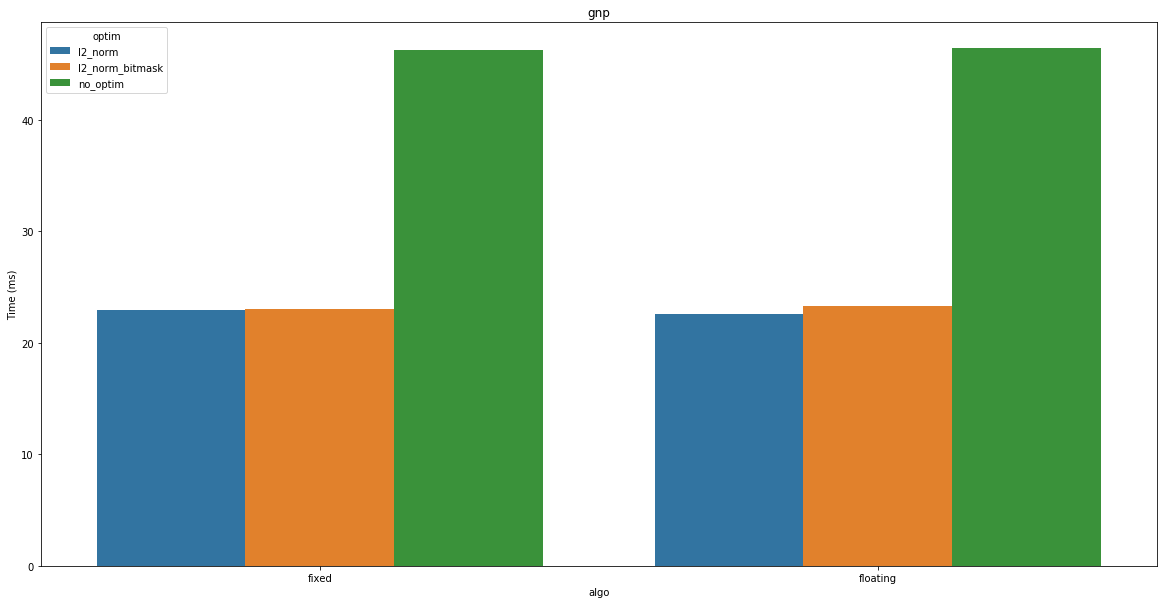

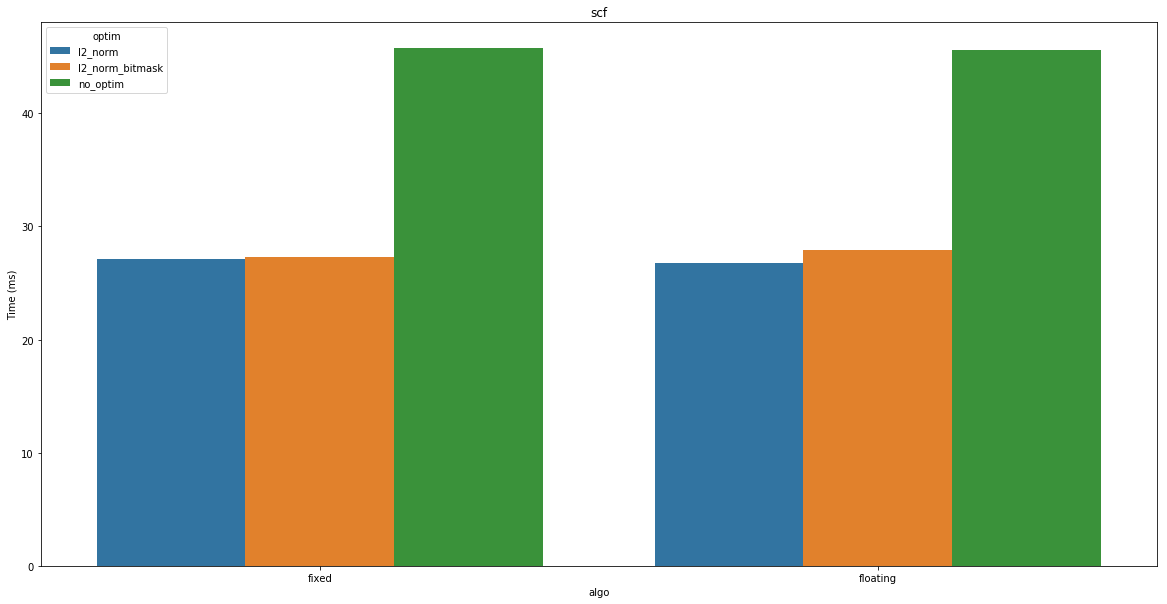

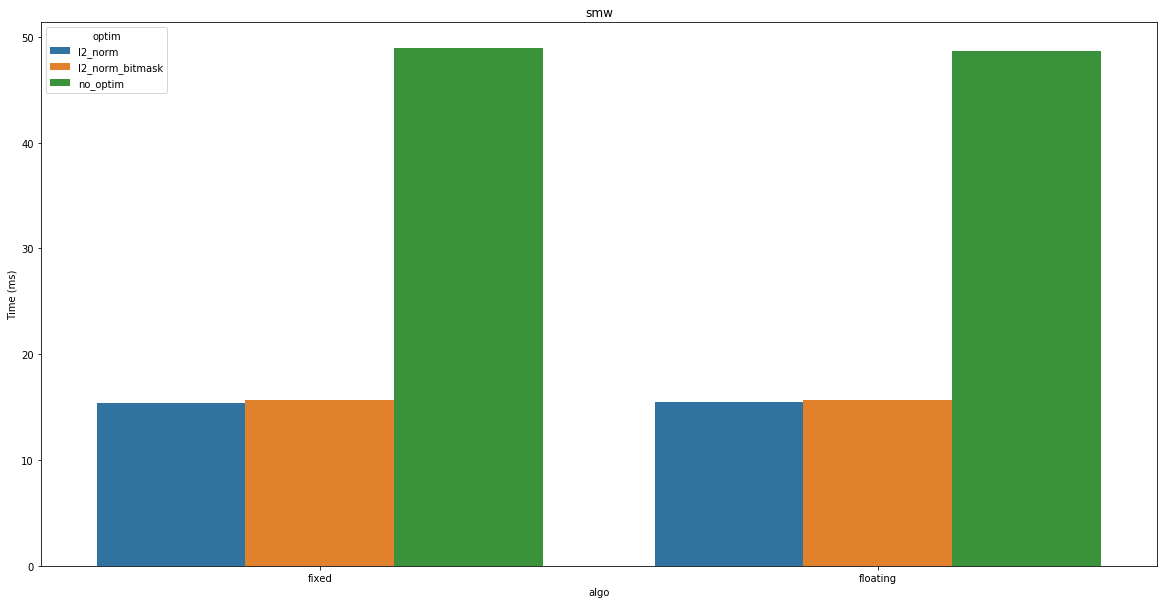

In [306]:
for idx, rest in times.groupby(["graph"]):
    plt.figure(figsize=(20, 10))
    ax = sns.barplot(x="algo", y="time", hue="optim", data=rest)
    ax.set_ylabel("Time (ms)")
    ax.set_title(idx)
    plt.savefig(f'figures/execution_time_all/{idx}.png')


In [312]:
best_performers = pd.DataFrame(columns=["graph","algo", "optim", "time"])

for g_idx, rest in times.groupby(["graph", "algo"]): 
    graph, algo = g_idx
    ds = {}
    ds["graph"] = graph
    ds["algo"] = algo
    ds["optim"] = rest[rest["time"] == rest["time"].min()]["optim"].values[0]
    ds["time"] = rest["time"].unique()[0]
    
    best_performers = best_performers.append(ds, ignore_index=True)
    
parra = {
    "graph": ["gnp", "scf", "smw"],
    "algo": ["baseline", "baseline", "baseline"],
    "optim": ["default","default","default"],
    "time": [109, 116, 85]
}

p_ds = pd.DataFrame(parra)
"""
networkx = {
    "graph": ["gnp", "scf", "smw"],
    "algo": ["nx", "nx", "nx"],
    "optim": ["default","default","default"],
    "time": [1.525076150894165 * 1000, 1.1051805019 * 1000, 1.12183453 * 1000]
}

nx_ds = pd.DataFrame(networkx)
"""
print()

In [313]:
#final = pd.concat([best_performers, p_ds])
#final = pd.concat([final, nx_ds])
#final = best_performers.append([p_ds, nx_ds])
final = best_performers.append([p_ds])
final.head()

,graph,algo,optim,time
0,gnp,fixed,l2_norm,22.909770
1,gnp,floating,l2_norm,22.548111
2,scf,fixed,l2_norm,27.125438
3,scf,floating,l2_norm,26.788497
4,smw,fixed,l2_norm,15.417548


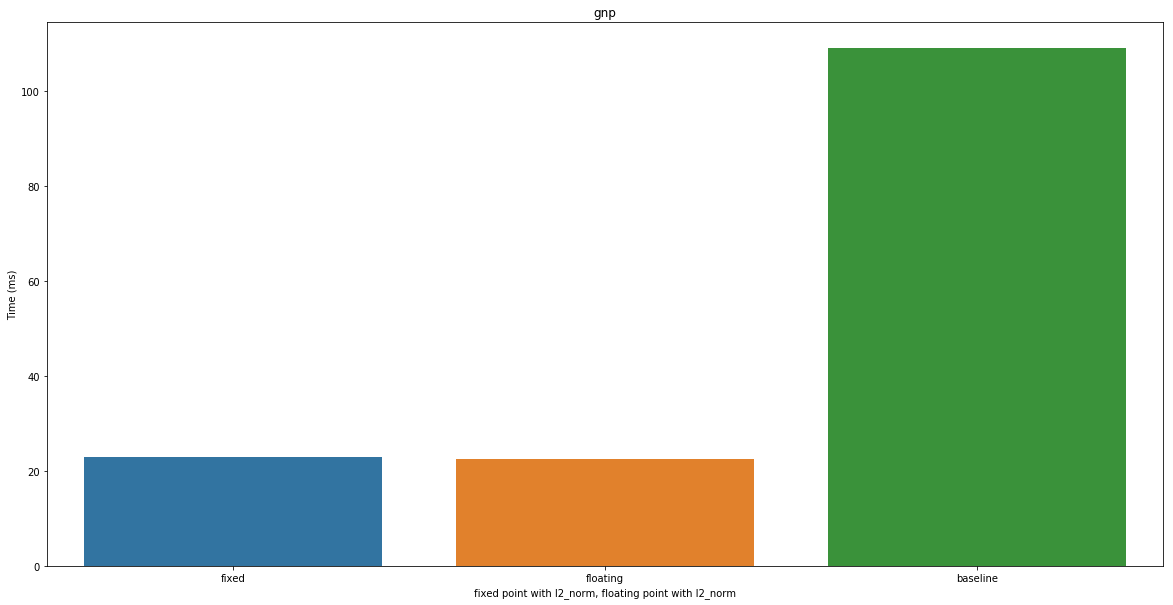

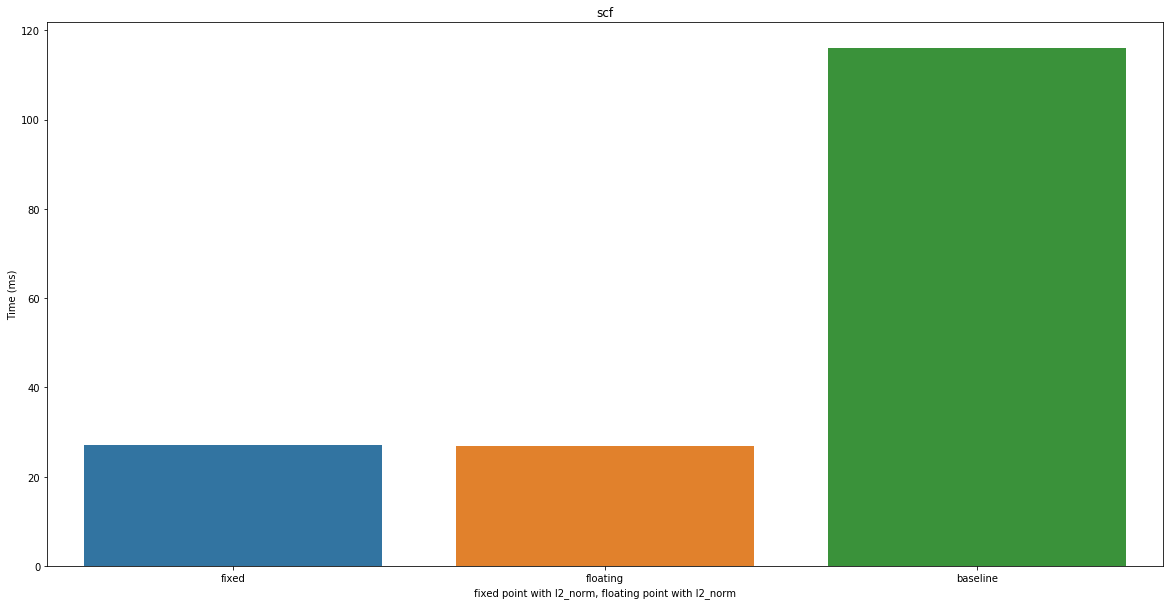

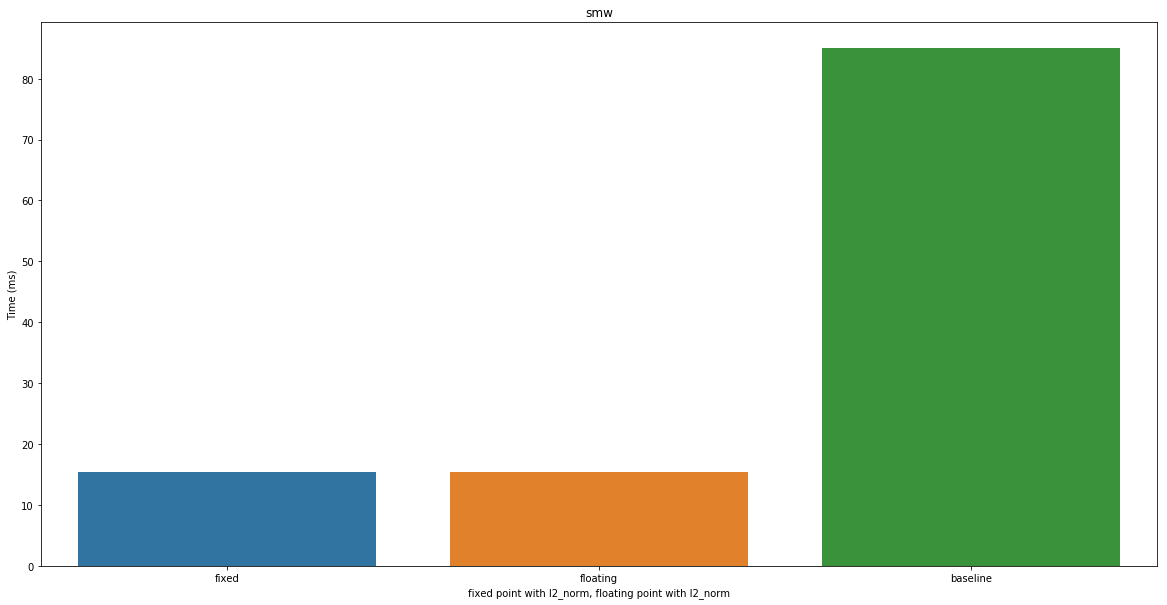

In [314]:
for idx, el in final.groupby("graph"): 
    plt.figure(figsize=(20, 10))
    ax = sns.barplot(x="algo", y="time", data=el)      
    ax.set_ylabel("Time (ms)")
    ax.set_title(idx)
    ax.set_xlabel("fixed point with {}, floating point with {}".format(el[el["algo"] == "fixed"]["optim"].values[0], el[el["algo"] == "floating"]["optim"].values[0]))
    #for index, row in el.iterrows():
    #    print((el[el["algo"] == 'baseline']["time"].values[0]) / row.time )
    #    ax.text(row.algo,row.time,(row.time / (el[el["algo"] == 'baseline']["time"].values[0])))
    plt.savefig(f'figures/execution_time/{idx}.png')
     
        